In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import math
%matplotlib inline
import matplotlib as plt

In [4]:
negative_with_seq = pd.read_csv("./data/negative_examples.csv")
positive_with_seq = pd.read_csv("./data/positive_examples.csv")

In [5]:
n = positive_with_seq["seq_new"].apply(lambda x: True if "N" in x else False)
np.where(n == True)

(array([ 15218,  15223,  15224, ..., 153676, 153677, 153678]),)

In [6]:
bases = dict(zip("ACGTN", [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]))
bases 


{'A': [1, 0, 0, 0, 0],
 'C': [0, 1, 0, 0, 0],
 'G': [0, 0, 1, 0, 0],
 'T': [0, 0, 0, 1, 0],
 'N': [0, 0, 0, 0, 1]}

In [8]:
X_positive = []
def encode(row):
    result = []
    for base in row:
        result.append(bases[base])
        
    X_positive.append(result)
positive_with_seq["seq_new"].apply(encode)
X_positive[0][0]

[1, 0, 0, 0, 0]

In [9]:
X_negative = []
def encode_neg(row):
    result = []
    for base in row:
        result.append(bases[base])
        
    X_negative.append(result)
negative_with_seq["seq_new"].apply(encode_neg)
X_negative[0][0]

[0, 0, 0, 1, 0]

In [11]:
features = np.concatenate((X_positive, X_negative), axis=0)
features.shape

(166348, 400, 5)

In [12]:
d = [bases["A"],bases["C"]]
e = [bases["A"],bases["C"], bases["A"], bases["C"]]
e

[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0]]

In [13]:
test_con = np.concatenate((d, e), axis=0)
test_con

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [14]:
test_con.shape

(6, 5)

In [15]:
Y_pos = [[1]] * len(X_positive)
Y_neg = [[0]] * len(X_negative)

In [16]:
labels = np.concatenate((Y_pos, Y_neg), axis=0)

In [17]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(features,
                                                    labels,
                                                    test_size=0.33,
                                                    random_state=42)


In [16]:
X_train.shape

(111453, 400, 5)

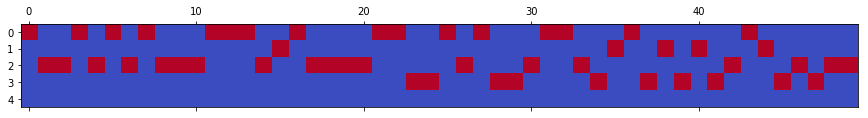

In [94]:
plt.pyplot.figure(figsize=(15, 5))
plt.pyplot.matshow(X_train[999,:50,:].transpose(), vmin=0, vmax=1, cmap=plt.pyplot.cm.coolwarm, fignum=0)


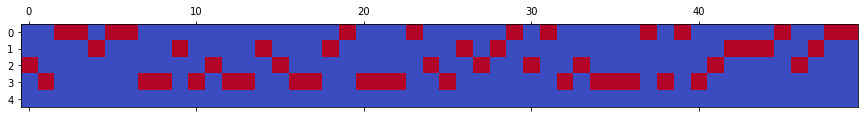

In [95]:
plt.pyplot.figure(figsize=(15, 5))
plt.pyplot.matshow(X_train[998,:50,:].transpose(), vmin=0, vmax=1, cmap=plt.pyplot.cm.coolwarm, fignum=0)


In [88]:
X_test.shape

(54895, 400, 5)

In [18]:
train_data = X_train.reshape([111453, 2000])
train_labels = y_train
eval_data = X_test.reshape([54895, 2000])
eval_labels = y_test

layer_1_nodes = 50
layer_2_nodes = 100
layer_3_nodes = 50
learning_rate = 0.001
training_epochs = 100
number_of_outputs = 1
number_of_inputs = 2000

In [90]:
train_data.shape

(111453, 2000)

In [18]:

tf.reset_default_graph()
# Input Layer
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, shape=(None, number_of_inputs), name="X")

# Layer 1
with tf.variable_scope('layer_1'):
    weights = tf.get_variable("weights1", shape=[number_of_inputs, layer_1_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases1", shape=[layer_1_nodes], initializer=tf.zeros_initializer())
    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):
    weights = tf.get_variable("weights2", shape=[layer_1_nodes, layer_2_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases2", shape=[layer_2_nodes], initializer=tf.zeros_initializer())
    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):
    weights = tf.get_variable("weights3", shape=[layer_2_nodes, layer_3_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases3", shape=[layer_3_nodes], initializer=tf.zeros_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output Layer
with tf.variable_scope('output'):
    weights = tf.get_variable("weights4", shape=[layer_3_nodes, number_of_outputs], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases4", shape=[number_of_outputs], initializer=tf.zeros_initializer())
    prediction = tf.matmul(layer_3_output, weights) + biases

# Section Two: Define the cost function of the neural network that will be optimized during training

with tf.variable_scope('cost'):
    Y = tf.placeholder(tf.float32, shape=(None, 1), name="Y")
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

# Section Three: Define the optimizer function that will be run to optimize the neural network

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Create a summary operation to log the progress of the network
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
RUN_NAME = "run 1 with 50 nodes"
# Initialize a session so that we can run TensorFlow operations
with tf.Session() as session:

    # Run the global variable initializer to initialize all variables and layers of the neural network
    session.run(tf.global_variables_initializer())

    # Create log file writers to record training progress.
    # We'll store training and testing log data separately.
    training_writer = tf.summary.FileWriter("./logs/{}/training".format(RUN_NAME), session.graph)
    testing_writer = tf.summary.FileWriter("./logs/{}/testing".format(RUN_NAME), session.graph)

    # Run the optimizer over and over to train the network.
    # One epoch is one full run through the training data set.
    for epoch in range(training_epochs):

        # Feed in the training data and do one step of neural network training
        session.run(optimizer, feed_dict={X: train_data, Y: train_labels})

        # Every few training steps, log our progress
        if epoch % 5 == 0:
            # Get the current accuracy scores by running the "cost" operation on the training and test data sets
            training_cost, training_summary = session.run([cost, summary], feed_dict={X: train_data, Y:train_labels})
            testing_cost, testing_summary = session.run([cost, summary], feed_dict={X: eval_data, Y:eval_labels})
    
            # Write the current training status to the log files (Which we can view with TensorBoard)
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)
    
            # Print the current training status to the screen
            print("Epoch: {} - Training Cost: {}  Testing Cost: {}".format(epoch, training_cost, testing_cost))

    # Training is now complete!

    # Get the final accuracy scores by running the "cost" operation on the training and test data sets
    final_training_cost = session.run(cost, feed_dict={X: train_data, Y: train_labels})
    final_testing_cost = session.run(cost, feed_dict={X: eval_data, Y: eval_labels})

    print("Final Training cost: {}".format(final_training_cost))
    print("Final Testing cost: {}".format(final_testing_cost))

Epoch: 0 - Training Cost: 0.27574580907821655  Testing Cost: 0.2755092680454254


Epoch: 5 - Training Cost: 0.08650205284357071  Testing Cost: 0.08527734130620956


Epoch: 10 - Training Cost: 0.08581047505140305  Testing Cost: 0.08379509299993515


Epoch: 15 - Training Cost: 0.0767461359500885  Testing Cost: 0.07513222098350525


Epoch: 20 - Training Cost: 0.07290595769882202  Testing Cost: 0.07081130146980286


Epoch: 25 - Training Cost: 0.07171355187892914  Testing Cost: 0.06977706402540207


Epoch: 30 - Training Cost: 0.0708940178155899  Testing Cost: 0.06887821108102798


Epoch: 35 - Training Cost: 0.0704510360956192  Testing Cost: 0.06846274435520172


Epoch: 40 - Training Cost: 0.07009609043598175  Testing Cost: 0.06811624765396118


Epoch: 45 - Training Cost: 0.06980448961257935  Testing Cost: 0.06788092106580734


Epoch: 50 - Training Cost: 0.06957345455884933  Testing Cost: 0.06763695925474167


Epoch: 55 - Training Cost: 0.06936056166887283  Testing Cost: 0.06752268970012665


Epoch: 60 - Training Cost: 0.06915020942687988  Testing Cost: 0.06726803630590439


Epoch: 65 - Training Cost: 0.06892603635787964  Testing Cost: 0.06714623421430588


Epoch: 70 - Training Cost: 0.06870535016059875  Testing Cost: 0.06690280884504318


Epoch: 75 - Training Cost: 0.0685320794582367  Testing Cost: 0.06676367670297623


Epoch: 80 - Training Cost: 0.0683937519788742  Testing Cost: 0.0666704848408699


Epoch: 85 - Training Cost: 0.06825468689203262  Testing Cost: 0.06652580201625824


Epoch: 90 - Training Cost: 0.06812041252851486  Testing Cost: 0.06643062084913254


Epoch: 95 - Training Cost: 0.0680062547326088  Testing Cost: 0.0663483664393425


Final Training cost: 0.06791766732931137
Final Testing cost: 0.06626623123884201


In [19]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(400, 5)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [20]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [28]:
model.fit(X_train, y_train, epochs=5)



Epoch 1/5
    32/111453 [..............................]    32/111453 [..............................] - ETA: 36s - loss: 0.1459 - acc: 0.9688

  1184/111453 [..............................]  1184/111453 [..............................] - ETA: 5s - loss: 0.2657 - acc: 0.9240 

  2144/111453 [..............................]  2144/111453 [..............................] - ETA: 5s - loss: 0.2650 - acc: 0.9249

  2976/111453 [..............................]  2976/111453 [..............................] - ETA: 5s - loss: 0.2627 - acc: 0.9254

  3936/111453 [>.............................]  3936/111453 [>.............................] - ETA: 5s - loss: 0.2654 - acc: 0.9245

  4928/111453 [>.............................]  4928/111453 [>.............................] - ETA: 5s - loss: 0.2623 - acc: 0.9257

  5920/111453 [>.............................]  5920/111453 [>.............................] - ETA: 5s - loss: 0.2592 - acc: 0.9269

  6816/111453 [>.............................]  6816/111453 [>.............................] - ETA: 5s - loss: 0.2623 - acc: 0.9256

  7520/111453 [=>............................]  7520/111453 [=>............................] - ETA: 5s - loss: 0.2603 - acc: 0.9265

  8352/111453 [=>............................]  8352/111453 [=>............................] - ETA: 5s - loss: 0.2601 - acc: 0.9264

  9024/111453 [=>............................]  9024/111453 [=>............................] - ETA: 5s - loss: 0.2577 - acc: 0.9274

  9696/111453 [=>............................]  9696/111453 [=>............................] - ETA: 6s - loss: 0.2579 - acc: 0.9272

 10656/111453 [=>............................] 10656/111453 [=>............................] - ETA: 5s - loss: 0.2582 - acc: 0.9270

 11552/111453 [==>...........................] 11552/111453 [==>...........................] - ETA: 5s - loss: 0.2585 - acc: 0.9271

 12512/111453 [==>...........................] 12512/111453 [==>...........................] - ETA: 5s - loss: 0.2588 - acc: 0.9270

 13344/111453 [==>...........................] 13344/111453 [==>...........................] - ETA: 5s - loss: 0.2613 - acc: 0.9260

 13888/111453 [==>...........................] 13888/111453 [==>...........................] - ETA: 5s - loss: 0.2605 - acc: 0.9263

 14592/111453 [==>...........................] 14592/111453 [==>...........................] - ETA: 5s - loss: 0.2602 - acc: 0.9265

 15264/111453 [===>..........................] 15264/111453 [===>..........................] - ETA: 5s - loss: 0.2607 - acc: 0.9262

 16000/111453 [===>..........................] 16000/111453 [===>..........................] - ETA: 5s - loss: 0.2599 - acc: 0.9265

 16608/111453 [===>..........................] 16608/111453 [===>..........................] - ETA: 5s - loss: 0.2604 - acc: 0.9263

 17248/111453 [===>..........................] 17248/111453 [===>..........................] - ETA: 5s - loss: 0.2605 - acc: 0.9263

 17984/111453 [===>..........................] 17984/111453 [===>..........................] - ETA: 5s - loss: 0.2591 - acc: 0.9268

 18784/111453 [====>.........................] 18784/111453 [====>.........................]

 - ETA: 5s - loss: 0.2604 - acc: 0.9264

 19456/111453 [====>.........................] 19456/111453 [====>.........................] - ETA: 5s - loss: 0.2596 - acc: 0.9267

 20192/111453 [====>.........................] 20192/111453 [====>.........................] - ETA: 5s - loss: 0.2593 - acc: 0.9268

 20896/111453 [====>.........................] 20896/111453 [====>.........................] - ETA: 5s - loss: 0.2606 - acc: 0.9263

 21664/111453 [====>.........................] 21664/111453 [====>.........................] - ETA: 5s - loss: 0.2607 - acc: 0.9263

 22496/111453 [=====>........................] 22496/111453 [=====>........................] - ETA: 5s - loss: 0.2600 - acc: 0.9266

 23424/111453 [=====>........................] 23424/111453 [=====>........................] - ETA: 5s - loss: 0.2600 - acc: 0.9267

 24064/111453 [=====>........................] 24064/111453 [=====>........................] - ETA: 5s - loss: 0.2613 - acc: 0.9261

 24832/111453 [=====>........................] 24832/111453 [=====>........................] - ETA: 5s - loss: 0.2621 - acc: 0.9257

 25632/111453 [=====>........................] 25632/111453 [=====>........................] - ETA: 5s - loss: 0.2621 - acc: 0.9257

 26336/111453 [======>.......................] 26336/111453 [======>.......................] - ETA: 5s - loss: 0.2610 - acc: 0.9262

 27040/111453 [======>.......................] 27040/111453 [======>.......................] - ETA: 5s - loss: 0.2618 - acc: 0.9259

 27776/111453 [======>.......................] 27776/111453 [======>.......................] - ETA: 5s - loss: 0.2609 - acc: 0.9262

 28512/111453 [======>.......................] 28512/111453 [======>.......................] - ETA: 5s - loss: 0.2605 - acc: 0.9263

 29408/111453 [======>.......................] 29408/111453 [======>.......................] - ETA: 5s - loss: 0.2592 - acc: 0.9268

 30208/111453 [=======>......................] 30208/111453 [=======>......................] - ETA: 5s - loss: 0.2581 - acc: 0.9272

 31040/111453 [=======>......................] 31040/111453 [=======>......................] - ETA: 5s - loss: 0.2572 - acc: 0.9276

 31872/111453 [=======>......................] 31872/111453 [=======>......................] - ETA: 5s - loss: 0.2574 - acc: 0.9275

 32736/111453 [=======>......................] 32736/111453 [=======>......................] - ETA: 5s - loss: 0.2573 - acc: 0.9276

 33632/111453 [========>.....................] 33632/111453 [========>.....................] - ETA: 5s - loss: 0.2567 - acc: 0.9278

 34528/111453 [========>.....................] 34528/111453 [========>.....................] - ETA: 4s - loss: 0.2571 - acc: 0.9277

 35424/111453 [========>.....................] 35424/111453 [========>.....................] - ETA: 4s - loss: 0.2575 - acc: 0.9276

 36128/111453 [========>.....................] 36128/111453 [========>.....................] - ETA: 4s - loss: 0.2571 - acc: 0.9277

 36928/111453 [========>.....................] 36928/111453 [========>.....................] - ETA: 4s - loss: 0.2571 - acc: 0.9278

 37664/111453 [=========>....................] 37664/111453 [=========>....................] - ETA: 4s - loss: 0.2572 - acc: 0.9277

 38496/111453 [=========>....................] 38496/111453 [=========>....................] - ETA: 4s - loss: 0.2583 - acc: 0.9273

 39328/111453 [=========>....................] 39328/111453 [=========>....................] - ETA: 4s - loss: 0.2583 - acc: 0.9273

 40032/111453 [=========>....................] 40032/111453 [=========>....................] - ETA: 4s - loss: 0.2575 - acc: 0.9276

 40736/111453 [=========>....................] 40736/111453 [=========>....................] - ETA: 4s - loss: 0.2587 - acc: 0.9271



 41632/111453 [==========>...................] 41632/111453 [==========>...................] - ETA: 4s - loss: 0.2587 - acc: 0.9271

 42592/111453 [==========>...................] 42592/111453 [==========>...................] - ETA: 4s - loss: 0.2596 - acc: 0.9268

 43488/111453 [==========>...................] 43488/111453 [==========>...................] - ETA: 4s - loss: 0.2591 - acc: 0.9270

 44352/111453 [==========>...................] 44352/111453 [==========>...................] - ETA: 4s - loss: 0.2586 - acc: 0.9272

 45408/111453 [===========>..................] 45408/111453 [===========>..................] - ETA: 4s - loss: 0.2595 - acc: 0.9268

 46464/111453 [===========>..................] 46464/111453 [===========>..................] - ETA: 4s - loss: 0.2592 - acc: 0.9269

 47552/111453 [===========>..................] 47552/111453 [===========>..................] - ETA: 4s - loss: 0.2589 - acc: 0.9270

 48608/111453 [============>.................] 48608/111453 [============>.................] - ETA: 3s - loss: 0.2585 - acc: 0.9272

 49696/111453 [============>.................] 49696/111453 [============>.................] - ETA: 3s - loss: 0.2586 - acc: 0.9272

 50752/111453 [============>.................] 50752/111453 [============>.................] - ETA: 3s - loss: 0.2589 - acc: 0.9271

 51872/111453 [============>.................] 51872/111453 [============>.................] - ETA: 3s - loss: 0.2582 - acc: 0.9274

 52864/111453 [=============>................] 52864/111453 [=============>................] - ETA: 3s - loss: 0.2580 - acc: 0.9275

 53792/111453 [=============>................] 53792/111453 [=============>................] - ETA: 3s - loss: 0.2583 - acc: 0.9274

 54624/111453 [=============>................] 54624/111453 [=============>................] - ETA: 3s - loss: 0.2581 - acc: 0.9275

 55616/111453 [=============>................] 55616/111453 [=============>................] - ETA: 3s - loss: 0.2585 - acc: 0.9274

 56704/111453 [==============>...............] 56704/111453 [==============>...............] - ETA: 3s - loss: 0.2587 - acc: 0.9273

 57760/111453 [==============>...............] 57760/111453 [==============>...............] - ETA: 3s - loss: 0.2592 - acc: 0.9272

 58816/111453 [==============>...............] 58816/111453 [==============>...............] - ETA: 3s - loss: 0.2590 - acc: 0.9272

 59904/111453 [===============>..............] 59904/111453 [===============>..............] - ETA: 3s - loss: 0.2585 - acc: 0.9275

 61024/111453 [===============>..............] 61024/111453 [===============>..............] - ETA: 3s - loss: 0.2578 - acc: 0.9277

 61920/111453 [===============>..............] 61920/111453 [===============>..............] - ETA: 2s - loss: 0.2578 - acc: 0.9277

 62912/111453 [===============>..............] 62912/111453 [===============>..............] - ETA: 2s - loss: 0.2581 - acc: 0.9276

 63872/111453 [================>.............] 63872/111453 [================>.............] - ETA: 2s - loss: 0.2582 - acc: 0.9276

 64800/111453 [================>.............] 64800/111453 [================>.............] - ETA: 2s - loss: 0.2587 - acc: 0.9274

 65856/111453 [================>.............] 65856/111453 [================>.............] - ETA: 2s - loss: 0.2584 - acc: 0.9275

 66880/111453 [=================>............] 66880/111453 [=================>............] - ETA: 2s - loss: 0.2583 - acc: 0.9276

 67968/111453 [=================>............] 67968/111453 [=================>............] - ETA: 2s - loss: 0.2583 - acc: 0.9276

 69088/111453 [=================>............] 69088/111453 [=================>............] - ETA: 2s - loss: 0.2583 - acc: 0.9276

 70144/111453 [=================>............] 70144/111453 [=================>............] - ETA: 2s - loss: 0.2580 - acc: 0.9277

 71232/111453 [==================>...........] 71232/111453 [==================>...........] - ETA: 2s - loss: 0.2580 - acc: 0.9277

 72256/111453 [==================>...........] 72256/111453 [==================>...........] - ETA: 2s - loss: 0.2581 - acc: 0.9276

 73536/111453 [==================>...........] 73536/111453 [==================>...........] - ETA: 2s - loss: 0.2580 - acc: 0.9277

 74624/111453 [===================>..........] 74624/111453 [===================>..........] - ETA: 2s - loss: 0.2583 - acc: 0.9276

 75968/111453 [===================>..........] 75968/111453 [===================>..........] - ETA: 2s - loss: 0.2586 - acc: 0.9275

 77248/111453 [===================>..........] 77248/111453 [===================>..........] - ETA: 1s - loss: 0.2580 - acc: 0.9277

 78624/111453 [====================>.........] 78624/111453 [====================>.........] - ETA: 1s - loss: 0.2574 - acc: 0.9279

 79904/111453 [====================>.........] 79904/111453 [====================>.........] - ETA: 1s - loss: 0.2576 - acc: 0.9279

 81312/111453 [====================>.........] 81312/111453 [====================>.........] - ETA: 1s - loss: 0.2577 - acc: 0.9279

 82624/111453 [=====================>........] 82624/111453 [=====================>........] - ETA: 1s - loss: 0.2578 - acc: 0.9278

 83808/111453 [=====================>........] 83808/111453 [=====================>........] - ETA: 1s - loss: 0.2576 - acc: 0.9279

 85152/111453 [=====================>........] 85152/111453 [=====================>........] - ETA: 1s - loss: 0.2577 - acc: 0.9279

 86496/111453 [======================>.......] 86496/111453 [======================>.......] - ETA: 1s - loss: 0.2578 - acc: 0.9279

 87776/111453 [======================>.......] 87776/111453 [======================>.......] - ETA: 1s - loss: 0.2582 - acc: 0.9277

 89056/111453 [======================>.......] 89056/111453 [======================>.......] - ETA: 1s - loss: 0.2578 - acc: 0.9279

 90464/111453 [=======================>......] 90464/111453 [=======================>......] - ETA: 1s - loss: 0.2572 - acc: 0.9281

 91840/111453 [=======================>......] 91840/111453 [=======================>......] - ETA: 1s - loss: 0.2576 - acc: 0.9279

 93216/111453 [========================>.....] 93216/111453 [========================>.....] - ETA: 0s - loss: 0.2574 - acc: 0.9280

 94592/111453 [========================>.....] 94592/111453 [========================>.....] - ETA: 0s - loss: 0.2575 - acc: 0.9280

 95968/111453 [========================>.....] 95968/111453 [========================>.....] - ETA: 0s - loss: 0.2572 - acc: 0.9281

 97344/111453 [=========================>....] 97344/111453 [=========================>....] - ETA: 0s - loss: 0.2569 - acc: 0.9282

 98752/111453 [=========================>....] 98752/111453 [=========================>....] - ETA: 0s - loss: 0.2570 - acc: 0.9281

 99968/111453 [=========================>....] 99968/111453 [=========================>....] - ETA: 0s - loss: 0.2573 - acc: 0.9280

101216/111453 [==========================>...]101216/111453 [==========================>...] - ETA: 0s - loss: 0.2567 - acc: 0.9282

102624/111453 [==========================>...]102624/111453 [==========================>...] - ETA: 0s - loss: 0.2569 - acc: 0.9282

104032/111453 [===========================>..]104032/111453 [===========================>..] - ETA: 0s - loss: 0.2567 - acc: 0.9283

105440/111453 [===========================>..]105440/111453 [===========================>..] - ETA: 0s - loss: 0.2567 - acc: 0.9283

106816/111453 [===========================>..]106816/111453 [===========================>..] - ETA: 0s - loss: 0.2569 - acc: 0.9282

108192/111453 [============================>.]108192/111453 [============================>.] - ETA: 0s - loss: 0.2568 - acc: 0.9282

109568/111453 [============================>.]109568/111453 [============================>.] - ETA: 0s - loss: 0.2565 - acc: 0.9284

110944/111453 [============================>.]110944/111453 [============================>.] - ETA: 0s - loss: 0.2566 - acc: 0.9283

111453/111453 [==============================]111453/111453 [==============================] - 6s 51us/step - loss: 0.2567 - acc: 0.9283



Epoch 2/5
    32/111453 [..............................]    32/111453 [..............................] - ETA: 21s - loss: 0.4016 - acc: 0.8750

  1152/111453 [..............................]  1152/111453 [..............................] - ETA: 5s - loss: 0.2223 - acc: 0.9401 

  2176/111453 [..............................]  2176/111453 [..............................] - ETA: 5s - loss: 0.2574 - acc: 0.9260

  3488/111453 [..............................]  3488/111453 [..............................] - ETA: 4s - loss: 0.2532 - acc: 0.9286

  4640/111453 [>.............................]  4640/111453 [>.............................] - ETA: 4s - loss: 0.2572 - acc: 0.9269

  5952/111453 [>.............................]  5952/111453 [>.............................] - ETA: 4s - loss: 0.2555 - acc: 0.9274

  6912/111453 [>.............................]  6912/111453 [>.............................] - ETA: 4s - loss: 0.2550 - acc: 0.9278

  7904/111453 [=>............................]  7904/111453 [=>............................] - ETA: 4s - loss: 0.2558 - acc: 0.9278

  9120/111453 [=>............................]  9120/111453 [=>............................] - ETA: 4s - loss: 0.2535 - acc: 0.9286

 10208/111453 [=>............................] 10208/111453 [=>............................] - ETA: 4s - loss: 0.2504 - acc: 0.9297

 11392/111453 [==>...........................] 11392/111453 [==>...........................] - ETA: 4s - loss: 0.2504 - acc: 0.9296

 12288/111453 [==>...........................] 12288/111453 [==>...........................] - ETA: 4s - loss: 0.2518 - acc: 0.9290

 13184/111453 [==>...........................] 13184/111453 [==>...........................] - ETA: 4s - loss: 0.2528 - acc: 0.9286

 14240/111453 [==>...........................] 14240/111453 [==>...........................] - ETA: 4s - loss: 0.2531 - acc: 0.9286

 15200/111453 [===>..........................] 15200/111453 [===>..........................] - ETA: 4s - loss: 0.2536 - acc: 0.9284

 16288/111453 [===>..........................] 16288/111453 [===>..........................] - ETA: 4s - loss: 0.2544 - acc: 0.9282

 17408/111453 [===>..........................] 17408/111453 [===>..........................] - ETA: 4s - loss: 0.2556 - acc: 0.9277

 18400/111453 [===>..........................] 18400/111453 [===>..........................] - ETA: 4s - loss: 0.2567 - acc: 0.9273

 19360/111453 [====>.........................] 19360/111453 [====>.........................] - ETA: 4s - loss: 0.2580 - acc: 0.9268

 20480/111453 [====>.........................] 20480/111453 [====>.........................] - ETA: 4s - loss: 0.2589 - acc: 0.9265

 21472/111453 [====>.........................] 21472/111453 [====>.........................] - ETA: 4s - loss: 0.2599 - acc: 0.9262

 22752/111453 [=====>........................] 22752/111453 [=====>........................] - ETA: 4s - loss: 0.2607 - acc: 0.9259

 24064/111453 [=====>........................] 24064/111453 [=====>........................] - ETA: 4s - loss: 0.2604 - acc: 0.9260

 25312/111453 [=====>........................] 25312/111453 [=====>........................] - ETA: 4s - loss: 0.2594 - acc: 0.9264

 26464/111453 [======>.......................] 26464/111453 [======>.......................] - ETA: 3s - loss: 0.2605 - acc: 0.9261

 27776/111453 [======>.......................] 27776/111453 [======>.......................] - ETA: 3s - loss: 0.2593 - acc: 0.9265

 28960/111453 [======>.......................] 28960/111453 [======>.......................] - ETA: 3s - loss: 0.2595 - acc: 0.9265

 29920/111453 [=======>......................] 29920/111453 [=======>......................] - ETA: 3s - loss: 0.2587 - acc: 0.9268

 30976/111453 [=======>......................] 30976/111453 [=======>......................] - ETA: 3s - loss: 0.2590 - acc: 0.9267

 31808/111453 [=======>......................] 31808/111453 [=======>......................] - ETA: 3s - loss: 0.2592 - acc: 0.9266

 32736/111453 [=======>......................] 32736/111453 [=======>......................] - ETA: 3s - loss: 0.2594 - acc: 0.9265

 33760/111453 [========>.....................] 33760/111453 [========>.....................] - ETA: 3s - loss: 0.2594 - acc: 0.9265

 34848/111453 [========>.....................] 34848/111453 [========>.....................] - ETA: 3s - loss: 0.2599 - acc: 0.9264

 36096/111453 [========>.....................] 36096/111453 [========>.....................] - ETA: 3s - loss: 0.2597 - acc: 0.9264

 37376/111453 [=========>....................] 37376/111453 [=========>....................] - ETA: 3s - loss: 0.2588 - acc: 0.9267

 38816/111453 [=========>....................] 38816/111453 [=========>....................] - ETA: 3s - loss: 0.2586 - acc: 0.9269

 40128/111453 [=========>....................] 40128/111453 [=========>....................] - ETA: 3s - loss: 0.2573 - acc: 0.9274

 41504/111453 [==========>...................] 41504/111453 [==========>...................] - ETA: 3s - loss: 0.2565 - acc: 0.9278

 42880/111453 [==========>...................] 42880/111453 [==========>...................] - ETA: 3s - loss: 0.2557 - acc: 0.9282

 44288/111453 [==========>...................] 44288/111453 [==========>...................] - ETA: 3s - loss: 0.2559 - acc: 0.9281

 45696/111453 [===========>..................] 45696/111453 [===========>..................] - ETA: 2s - loss: 0.2559 - acc: 0.9281

 46976/111453 [===========>..................] 46976/111453 [===========>..................] - ETA: 2s - loss: 0.2558 - acc: 0.9282

 48192/111453 [===========>..................] 48192/111453 [===========>..................] - ETA: 2s - loss: 0.2562 - acc: 0.9280

 49312/111453 [============>.................] 49312/111453 [============>.................] - ETA: 2s - loss: 0.2560 - acc: 0.9281

 50720/111453 [============>.................] 50720/111453 [============>.................] - ETA: 2s - loss: 0.2567 - acc: 0.9279

 52128/111453 [=============>................] 52128/111453 [=============>................] - ETA: 2s - loss: 0.2569 - acc: 0.9278

 53536/111453 [=============>................] 53536/111453 [=============>................] - ETA: 2s - loss: 0.2563 - acc: 0.9280

 54912/111453 [=============>................] 54912/111453 [=============>................] - ETA: 2s - loss: 0.2556 - acc: 0.9284

 56320/111453 [==============>...............] 56320/111453 [==============>...............] - ETA: 2s - loss: 0.2553 - acc: 0.9285

 57696/111453 [==============>...............] 57696/111453 [==============>...............] - ETA: 2s - loss: 0.2550 - acc: 0.9286

 59104/111453 [==============>...............] 59104/111453 [==============>...............] - ETA: 2s - loss: 0.2545 - acc: 0.9288

 60416/111453 [===============>..............] 60416/111453 [===============>..............] - ETA: 2s - loss: 0.2550 - acc: 0.9286

 61632/111453 [===============>..............] 61632/111453 [===============>..............] - ETA: 2s - loss: 0.2547 - acc: 0.9287

 62624/111453 [===============>..............] 62624/111453 [===============>..............] - ETA: 2s - loss: 0.2544 - acc: 0.9288

 63552/111453 [================>.............] 63552/111453 [================>.............] - ETA: 2s - loss: 0.2545 - acc: 0.9288

 64640/111453 [================>.............] 64640/111453 [================>.............] - ETA: 2s - loss: 0.2553 - acc: 0.9285

 66048/111453 [================>.............] 66048/111453 [================>.............] - ETA: 1s - loss: 0.2552 - acc: 0.9286

 67200/111453 [=================>............] 67200/111453 [=================>............] - ETA: 1s - loss: 0.2552 - acc: 0.9286

 68640/111453 [=================>............] 68640/111453 [=================>............] - ETA: 1s - loss: 0.2556 - acc: 0.9285

 70016/111453 [=================>............] 70016/111453 [=================>............] - ETA: 1s - loss: 0.2555 - acc: 0.9285

 71328/111453 [==================>...........] 71328/111453 [==================>...........] - ETA: 1s - loss: 0.2555 - acc: 0.9285

 72288/111453 [==================>...........] 72288/111453 [==================>...........] - ETA: 1s - loss: 0.2564 - acc: 0.9281

 73408/111453 [==================>...........] 73408/111453 [==================>...........] - ETA: 1s - loss: 0.2568 - acc: 0.9280

 74368/111453 [===================>..........] 74368/111453 [===================>..........] - ETA: 1s - loss: 0.2570 - acc: 0.9279

 75520/111453 [===================>..........] 75520/111453 [===================>..........] - ETA: 1s - loss: 0.2571 - acc: 0.9278

 76480/111453 [===================>..........] 76480/111453 [===================>..........] - ETA: 1s - loss: 0.2574 - acc: 0.9277

 77472/111453 [===================>..........] 77472/111453 [===================>..........] - ETA: 1s - loss: 0.2573 - acc: 0.9278

 78496/111453 [====================>.........] 78496/111453 [====================>.........] - ETA: 1s - loss: 0.2574 - acc: 0.9278

 79424/111453 [====================>.........] 79424/111453 [====================>.........] - ETA: 1s - loss: 0.2573 - acc: 0.9278

 80512/111453 [====================>.........] 80512/111453 [====================>.........] - ETA: 1s - loss: 0.2571 - acc: 0.9279

 81760/111453 [=====================>........] 81760/111453 [=====================>........] - ETA: 1s - loss: 0.2573 - acc: 0.9278

 82784/111453 [=====================>........] 82784/111453 [=====================>........] - ETA: 1s - loss: 0.2576 - acc: 0.9277

 84032/111453 [=====================>........] 84032/111453 [=====================>........] - ETA: 1s - loss: 0.2573 - acc: 0.9278

 85088/111453 [=====================>........] 85088/111453 [=====================>........] - ETA: 1s - loss: 0.2576 - acc: 0.9277

 86368/111453 [======================>.......] 86368/111453 [======================>.......] - ETA: 1s - loss: 0.2578 - acc: 0.9277

 87616/111453 [======================>.......] 87616/111453 [======================>.......] - ETA: 1s - loss: 0.2579 - acc: 0.9276

 88960/111453 [======================>.......] 88960/111453 [======================>.......] - ETA: 0s - loss: 0.2580 - acc: 0.9276

 90272/111453 [=======================>......] 90272/111453 [=======================>......] - ETA: 0s - loss: 0.2586 - acc: 0.9273

 91680/111453 [=======================>......] 91680/111453 [=======================>......] - ETA: 0s - loss: 0.2587 - acc: 0.9273

 92736/111453 [=======================>......] 92736/111453 [=======================>......] - ETA: 0s - loss: 0.2583 - acc: 0.9275

 94016/111453 [========================>.....] 94016/111453 [========================>.....] - ETA: 0s - loss: 0.2579 - acc: 0.9276

 95200/111453 [========================>.....] 95200/111453 [========================>.....] - ETA: 0s - loss: 0.2577 - acc: 0.9277

 96512/111453 [========================>.....] 96512/111453 [========================>.....] - ETA: 0s - loss: 0.2577 - acc: 0.9277

 97792/111453 [=========================>....] 97792/111453 [=========================>....] - ETA: 0s - loss: 0.2575 - acc: 0.9278

 99072/111453 [=========================>....] 99072/111453 [=========================>....] - ETA: 0s - loss: 0.2572 - acc: 0.9279

100160/111453 [=========================>....]100160/111453 [=========================>....] - ETA: 0s - loss: 0.2573 - acc: 0.9279

101472/111453 [==========================>...]101472/111453 [==========================>...] - ETA: 0s - loss: 0.2572 - acc: 0.9280

102720/111453 [==========================>...]102720/111453 [==========================>...] - ETA: 0s - loss: 0.2572 - acc: 0.9280

103776/111453 [==========================>...]103776/111453 [==========================>...] - ETA: 0s - loss: 0.2573 - acc: 0.9279

104736/111453 [===========================>..]104736/111453 [===========================>..] - ETA: 0s - loss: 0.2569 - acc: 0.9281

105696/111453 [===========================>..]105696/111453 [===========================>..] - ETA: 0s - loss: 0.2567 - acc: 0.9282

106656/111453 [===========================>..]106656/111453 [===========================>..] - ETA: 0s - loss: 0.2562 - acc: 0.9284

107552/111453 [===========================>..]107552/111453 [===========================>..] - ETA: 0s - loss: 0.2560 - acc: 0.9284

108320/111453 [============================>.]108320/111453 [============================>.] - ETA: 0s - loss: 0.2559 - acc: 0.9285

109152/111453 [============================>.]109152/111453 [============================>.] - ETA: 0s - loss: 0.2561 - acc: 0.9284

109952/111453 [============================>.]109952/111453 [============================>.] - ETA: 0s - loss: 0.2561 - acc: 0.9284

110784/111453 [============================>.]110784/111453 [============================>.] - ETA: 0s - loss: 0.2562 - acc: 0.9284

111453/111453 [==============================]111453/111453 [==============================] - 5s 44us/step - loss: 0.2562 - acc: 0.9284



Epoch 3/5


    32/111453 [..............................]    32/111453 [..............................] - ETA: 27s - loss: 0.2196 - acc: 0.9375

   960/111453 [..............................]   960/111453 [..............................] - ETA: 6s - loss: 0.2473 - acc: 0.9313 

  1760/111453 [..............................]  1760/111453 [..............................] - ETA: 6s - loss: 0.2312 - acc: 0.9375

  2528/111453 [..............................]  2528/111453 [..............................] - ETA: 6s - loss: 0.2288 - acc: 0.9375

  3360/111453 [..............................]  3360/111453 [..............................] - ETA: 6s - loss: 0.2264 - acc: 0.9384

  4288/111453 [>.............................]  4288/111453 [>.............................] - ETA: 6s - loss: 0.2273 - acc: 0.9382

  5248/111453 [>.............................]  5248/111453 [>.............................] - ETA: 6s - loss: 0.2322 - acc: 0.9364

  6208/111453 [>.............................]  6208/111453 [>.............................] - ETA: 6s - loss: 0.2345 - acc: 0.9354

  7200/111453 [>.............................]  7200/111453 [>.............................] - ETA: 6s - loss: 0.2360 - acc: 0.9350

  8192/111453 [=>............................]  8192/111453 [=>............................] - ETA: 5s - loss: 0.2369 - acc: 0.9346

  9184/111453 [=>............................]  9184/111453 [=>............................] - ETA: 5s - loss: 0.2349 - acc: 0.9351

 10208/111453 [=>............................] 10208/111453 [=>............................] - ETA: 5s - loss: 0.2351 - acc: 0.9350

 10976/111453 [=>............................] 10976/111453 [=>............................] - ETA: 5s - loss: 0.2396 - acc: 0.9332

 11616/111453 [==>...........................] 11616/111453 [==>...........................] - ETA: 5s - loss: 0.2413 - acc: 0.9327

 12384/111453 [==>...........................] 12384/111453 [==>...........................] - ETA: 5s - loss: 0.2404 - acc: 0.9331

 13056/111453 [==>...........................] 13056/111453 [==>...........................] - ETA: 5s - loss: 0.2416 - acc: 0.9326

 13696/111453 [==>...........................] 13696/111453 [==>...........................] - ETA: 5s - loss: 0.2408 - acc: 0.9330

 14400/111453 [==>...........................] 14400/111453 [==>...........................] - ETA: 5s - loss: 0.2404 - acc: 0.9332

 15168/111453 [===>..........................] 15168/111453 [===>..........................] - ETA: 5s - loss: 0.2399 - acc: 0.9334

 15968/111453 [===>..........................] 15968/111453 [===>..........................] - ETA: 5s - loss: 0.2408 - acc: 0.9332

 17024/111453 [===>..........................] 17024/111453 [===>..........................] - ETA: 5s - loss: 0.2407 - acc: 0.9333

 17824/111453 [===>..........................] 17824/111453 [===>..........................] - ETA: 5s - loss: 0.2411 - acc: 0.9331

 18784/111453 [====>.........................] 18784/111453 [====>.........................] - ETA: 5s - loss: 0.2421 - acc: 0.9328

 19840/111453 [====>.........................] 19840/111453 [====>.........................] - ETA: 5s - loss: 0.2424 - acc: 0.9326

 21024/111453 [====>.........................] 21024/111453 [====>.........................] - ETA: 5s - loss: 0.2441 - acc: 0.9320

 22240/111453 [====>.........................] 22240/111453 [====>.........................] - ETA: 5s - loss: 0.2451 - acc: 0.9317

 23648/111453 [=====>........................] 23648/111453 [=====>........................] - ETA: 4s - loss: 0.2448 - acc: 0.9317

 25056/111453 [=====>........................] 25056/111453 [=====>........................] - ETA: 4s - loss: 0.2459 - acc: 0.9313

 26464/111453 [======>.......................] 26464/111453 [======>.......................] - ETA: 4s - loss: 0.2465 - acc: 0.9312

 27840/111453 [======>.......................] 27840/111453 [======>.......................] - ETA: 4s - loss: 0.2467 - acc: 0.9313

 29120/111453 [======>.......................] 29120/111453 [======>.......................] - ETA: 4s - loss: 0.2465 - acc: 0.9313

 30496/111453 [=======>......................] 30496/111453 [=======>......................] - ETA: 4s - loss: 0.2468 - acc: 0.9312

 31904/111453 [=======>......................] 31904/111453 [=======>......................] - ETA: 4s - loss: 0.2461 - acc: 0.9315

 33280/111453 [=======>......................] 33280/111453 [=======>......................] - ETA: 3s - loss: 0.2484 - acc: 0.9306

 34240/111453 [========>.....................] 34240/111453 [========>.....................] - ETA: 3s - loss: 0.2482 - acc: 0.9308

 35616/111453 [========>.....................] 35616/111453 [========>.....................] - ETA: 3s - loss: 0.2486 - acc: 0.9306

 36992/111453 [========>.....................] 36992/111453 [========>.....................] - ETA: 3s - loss: 0.2481 - acc: 0.9308

 38240/111453 [=========>....................] 38240/111453 [=========>....................] - ETA: 3s - loss: 0.2488 - acc: 0.9305

 39360/111453 [=========>....................] 39360/111453 [=========>....................] - ETA: 3s - loss: 0.2496 - acc: 0.9302

 40672/111453 [=========>....................] 40672/111453 [=========>....................] - ETA: 3s - loss: 0.2507 - acc: 0.9298

 41920/111453 [==========>...................] 41920/111453 [==========>...................] - ETA: 3s - loss: 0.2510 - acc: 0.9297

 43168/111453 [==========>...................] 43168/111453 [==========>...................] - ETA: 3s - loss: 0.2513 - acc: 0.9296

 44512/111453 [==========>...................] 44512/111453 [==========>...................] - ETA: 3s - loss: 0.2509 - acc: 0.9298

 45568/111453 [===========>..................] 45568/111453 [===========>..................] - ETA: 3s - loss: 0.2505 - acc: 0.9300

 46848/111453 [===========>..................] 46848/111453 [===========>..................] - ETA: 3s - loss: 0.2508 - acc: 0.9299

 47840/111453 [===========>..................] 47840/111453 [===========>..................] - ETA: 3s - loss: 0.2501 - acc: 0.9301

 49024/111453 [============>.................] 49024/111453 [============>.................] - ETA: 2s - loss: 0.2497 - acc: 0.9303

 50464/111453 [============>.................] 50464/111453 [============>.................] - ETA: 2s - loss: 0.2499 - acc: 0.9302

 51872/111453 [============>.................] 51872/111453 [============>.................] - ETA: 2s - loss: 0.2504 - acc: 0.9300

 53280/111453 [=============>................] 53280/111453 [=============>................] - ETA: 2s - loss: 0.2508 - acc: 0.9299

 54688/111453 [=============>................] 54688/111453 [=============>................] - ETA: 2s - loss: 0.2515 - acc: 0.9296

 56096/111453 [==============>...............] 56096/111453 [==============>...............] - ETA: 2s - loss: 0.2516 - acc: 0.9296

 57472/111453 [==============>...............] 57472/111453 [==============>...............] - ETA: 2s - loss: 0.2517 - acc: 0.9295

 58784/111453 [==============>...............] 58784/111453 [==============>...............] - ETA: 2s - loss: 0.2522 - acc: 0.9294

 60064/111453 [===============>..............] 60064/111453 [===============>..............] - ETA: 2s - loss: 0.2516 - acc: 0.9296

 61280/111453 [===============>..............] 61280/111453 [===============>..............] - ETA: 2s - loss: 0.2517 - acc: 0.9296

 62688/111453 [===============>..............] 62688/111453 [===============>..............] - ETA: 2s - loss: 0.2520 - acc: 0.9295

 63968/111453 [================>.............] 63968/111453 [================>.............] - ETA: 2s - loss: 0.2526 - acc: 0.9293

 65216/111453 [================>.............] 65216/111453 [================>.............] - ETA: 2s - loss: 0.2524 - acc: 0.9294

 66080/111453 [================>.............] 66080/111453 [================>.............] - ETA: 2s - loss: 0.2524 - acc: 0.9294

 66944/111453 [=================>............] 66944/111453 [=================>............] - ETA: 2s - loss: 0.2526 - acc: 0.9293

 67904/111453 [=================>............] 67904/111453 [=================>............] - ETA: 1s - loss: 0.2525 - acc: 0.9293

 68992/111453 [=================>............] 68992/111453 [=================>............] - ETA: 1s - loss: 0.2529 - acc: 0.9292

 69984/111453 [=================>............] 69984/111453 [=================>............] - ETA: 1s - loss: 0.2528 - acc: 0.9292

 71296/111453 [==================>...........] 71296/111453 [==================>...........] - ETA: 1s - loss: 0.2529 - acc: 0.9292

 72384/111453 [==================>...........] 72384/111453 [==================>...........] - ETA: 1s - loss: 0.2527 - acc: 0.9293

 73728/111453 [==================>...........] 73728/111453 [==================>...........] - ETA: 1s - loss: 0.2527 - acc: 0.9293

 74816/111453 [===================>..........] 74816/111453 [===================>..........] - ETA: 1s - loss: 0.2531 - acc: 0.9291

 76288/111453 [===================>..........] 76288/111453 [===================>..........] - ETA: 1s - loss: 0.2535 - acc: 0.9290

 77696/111453 [===================>..........] 77696/111453 [===================>..........] - ETA: 1s - loss: 0.2535 - acc: 0.9291

 79072/111453 [====================>.........] 79072/111453 [====================>.........] - ETA: 1s - loss: 0.2539 - acc: 0.9289

 80480/111453 [====================>.........] 80480/111453 [====================>.........] - ETA: 1s - loss: 0.2541 - acc: 0.9288

 81856/111453 [=====================>........] 81856/111453 [=====================>........] - ETA: 1s - loss: 0.2541 - acc: 0.9289

 83168/111453 [=====================>........] 83168/111453 [=====================>........] - ETA: 1s - loss: 0.2544 - acc: 0.9287

 84480/111453 [=====================>........] 84480/111453 [=====================>........] - ETA: 1s - loss: 0.2539 - acc: 0.9289

 85536/111453 [======================>.......] 85536/111453 [======================>.......] - ETA: 1s - loss: 0.2536 - acc: 0.9291

 86976/111453 [======================>.......] 86976/111453 [======================>.......] - ETA: 1s - loss: 0.2541 - acc: 0.9289

 88384/111453 [======================>.......] 88384/111453 [======================>.......] - ETA: 1s - loss: 0.2544 - acc: 0.9287

 89824/111453 [=======================>......] 89824/111453 [=======================>......] - ETA: 0s - loss: 0.2543 - acc: 0.9288

 91264/111453 [=======================>......] 91264/111453 [=======================>......] - ETA: 0s - loss: 0.2546 - acc: 0.9287

 92672/111453 [=======================>......] 92672/111453 [=======================>......] - ETA: 0s - loss: 0.2549 - acc: 0.9286

 94080/111453 [========================>.....] 94080/111453 [========================>.....] - ETA: 0s - loss: 0.2548 - acc: 0.9286

 95392/111453 [========================>.....] 95392/111453 [========================>.....] - ETA: 0s - loss: 0.2544 - acc: 0.9287

 96736/111453 [=========================>....] 96736/111453 [=========================>....] - ETA: 0s - loss: 0.2547 - acc: 0.9287

 98048/111453 [=========================>....] 98048/111453 [=========================>....] - ETA: 0s - loss: 0.2544 - acc: 0.9288

 99456/111453 [=========================>....] 99456/111453 [=========================>....] - ETA: 0s - loss: 0.2546 - acc: 0.9287

100704/111453 [==========================>...]100704/111453 [==========================>...] - ETA: 0s - loss: 0.2547 - acc: 0.9287

101696/111453 [==========================>...]101696/111453 [==========================>...] - ETA: 0s - loss: 0.2548 - acc: 0.9286

102656/111453 [==========================>...]102656/111453 [==========================>...] - ETA: 0s - loss: 0.2549 - acc: 0.9286

103744/111453 [==========================>...]103744/111453 [==========================>...] - ETA: 0s - loss: 0.2552 - acc: 0.9285

105152/111453 [===========================>..]105152/111453 [===========================>..] - ETA: 0s - loss: 0.2554 - acc: 0.9284

106496/111453 [===========================>..]106496/111453 [===========================>..] - ETA: 0s - loss: 0.2554 - acc: 0.9284

107936/111453 [============================>.]107936/111453 [============================>.] - ETA: 0s - loss: 0.2558 - acc: 0.9283

109248/111453 [============================>.]109248/111453 [============================>.] - ETA: 0s - loss: 0.2555 - acc: 0.9284

110624/111453 [============================>.]110624/111453 [============================>.] - ETA: 0s - loss: 0.2556 - acc: 0.9284

111453/111453 [==============================]111453/111453 [==============================] - 5s 43us/step - loss: 0.2554 - acc: 0.9285



Epoch 4/5


    32/111453 [..............................]    32/111453 [..............................] - ETA: 23s - loss: 0.1331 - acc: 0.9688

   992/111453 [..............................]   992/111453 [..............................] - ETA: 6s - loss: 0.2515 - acc: 0.9294 

  1920/111453 [..............................]  1920/111453 [..............................] - ETA: 6s - loss: 0.2808 - acc: 0.9172

  3104/111453 [..............................]  3104/111453 [..............................] - ETA: 5s - loss: 0.2663 - acc: 0.9227

  4512/111453 [>.............................]  4512/111453 [>.............................] - ETA: 4s - loss: 0.2620 - acc: 0.9246

  5792/111453 [>.............................]  5792/111453 [>.............................] - ETA: 4s - loss: 0.2524 - acc: 0.9282

  7232/111453 [>.............................]  7232/111453 [>.............................] - ETA: 4s - loss: 0.2547 - acc: 0.9274

  8448/111453 [=>............................]  8448/111453 [=>............................] - ETA: 4s - loss: 0.2582 - acc: 0.9261

  9568/111453 [=>............................]  9568/111453 [=>............................] - ETA: 4s - loss: 0.2570 - acc: 0.9266

 10976/111453 [=>............................] 10976/111453 [=>............................] - ETA: 4s - loss: 0.2568 - acc: 0.9269

 12384/111453 [==>...........................] 12384/111453 [==>...........................] - ETA: 4s - loss: 0.2543 - acc: 0.9279

 13824/111453 [==>...........................] 13824/111453 [==>...........................] - ETA: 3s - loss: 0.2538 - acc: 0.9280

 15264/111453 [===>..........................] 15264/111453 [===>..........................] - ETA: 3s - loss: 0.2525 - acc: 0.9286

 16704/111453 [===>..........................] 16704/111453 [===>..........................] - ETA: 3s - loss: 0.2508 - acc: 0.9293

 18144/111453 [===>..........................] 18144/111453 [===>..........................] - ETA: 3s - loss: 0.2537 - acc: 0.9282

 19552/111453 [====>.........................] 19552/111453 [====>.........................] - ETA: 3s - loss: 0.2543 - acc: 0.9280

 20960/111453 [====>.........................] 20960/111453 [====>.........................] - ETA: 3s - loss: 0.2531 - acc: 0.9285

 22272/111453 [====>.........................] 22272/111453 [====>.........................] - ETA: 3s - loss: 0.2531 - acc: 0.9285

 23648/111453 [=====>........................] 23648/111453 [=====>........................] - ETA: 3s - loss: 0.2526 - acc: 0.9286

 24672/111453 [=====>........................] 24672/111453 [=====>........................] - ETA: 3s - loss: 0.2529 - acc: 0.9286

 25824/111453 [=====>........................] 25824/111453 [=====>........................] - ETA: 3s - loss: 0.2518 - acc: 0.9290

 26816/111453 [======>.......................] 26816/111453 [======>.......................] - ETA: 3s - loss: 0.2526 - acc: 0.9288

 27872/111453 [======>.......................] 27872/111453 [======>.......................] - ETA: 3s - loss: 0.2527 - acc: 0.9288

 28832/111453 [======>.......................] 28832/111453 [======>.......................] - ETA: 3s - loss: 0.2529 - acc: 0.9288

 29920/111453 [=======>......................] 29920/111453 [=======>......................] - ETA: 3s - loss: 0.2539 - acc: 0.9284

 30912/111453 [=======>......................] 30912/111453 [=======>......................] - ETA: 3s - loss: 0.2541 - acc: 0.9283

 32096/111453 [=======>......................] 32096/111453 [=======>......................] - ETA: 3s - loss: 0.2546 - acc: 0.9281

 32960/111453 [=======>......................] 32960/111453 [=======>......................] - ETA: 3s - loss: 0.2542 - acc: 0.9283

 33920/111453 [========>.....................] 33920/111453 [========>.....................] - ETA: 3s - loss: 0.2535 - acc: 0.9286

 35104/111453 [========>.....................] 35104/111453 [========>.....................] - ETA: 3s - loss: 0.2548 - acc: 0.9281

 36128/111453 [========>.....................] 36128/111453 [========>.....................] - ETA: 3s - loss: 0.2544 - acc: 0.9282

 37056/111453 [========>.....................] 37056/111453 [========>.....................] - ETA: 3s - loss: 0.2534 - acc: 0.9286

 38048/111453 [=========>....................] 38048/111453 [=========>....................] - ETA: 3s - loss: 0.2533 - acc: 0.9286

 39168/111453 [=========>....................] 39168/111453 [=========>....................] - ETA: 3s - loss: 0.2534 - acc: 0.9286

 40256/111453 [=========>....................] 40256/111453 [=========>....................] - ETA: 3s - loss: 0.2536 - acc: 0.9285

 41312/111453 [==========>...................] 41312/111453 [==========>...................] - ETA: 3s - loss: 0.2526 - acc: 0.9289

 42112/111453 [==========>...................] 42112/111453 [==========>...................] - ETA: 3s - loss: 0.2524 - acc: 0.9290

 42848/111453 [==========>...................] 42848/111453 [==========>...................] - ETA: 3s - loss: 0.2525 - acc: 0.9290

 43744/111453 [==========>...................] 43744/111453 [==========>...................] - ETA: 2s - loss: 0.2530 - acc: 0.9289

 44864/111453 [===========>..................] 44864/111453 [===========>..................] - ETA: 2s - loss: 0.2533 - acc: 0.9288

 46144/111453 [===========>..................] 46144/111453 [===========>..................] - ETA: 2s - loss: 0.2535 - acc: 0.9287

 47552/111453 [===========>..................] 47552/111453 [===========>..................] - ETA: 2s - loss: 0.2538 - acc: 0.9286

 48992/111453 [============>.................] 48992/111453 [============>.................] - ETA: 2s - loss: 0.2540 - acc: 0.9285

 50432/111453 [============>.................] 50432/111453 [============>.................] - ETA: 2s - loss: 0.2542 - acc: 0.9285

 51712/111453 [============>.................] 51712/111453 [============>.................] - ETA: 2s - loss: 0.2536 - acc: 0.9288

 53056/111453 [=============>................] 53056/111453 [=============>................] - ETA: 2s - loss: 0.2546 - acc: 0.9285

 54240/111453 [=============>................] 54240/111453 [=============>................] - ETA: 2s - loss: 0.2546 - acc: 0.9285

 55360/111453 [=============>................] 55360/111453 [=============>................] - ETA: 2s - loss: 0.2546 - acc: 0.9285

 56544/111453 [==============>...............] 56544/111453 [==============>...............] - ETA: 2s - loss: 0.2548 - acc: 0.9284

 57664/111453 [==============>...............] 57664/111453 [==============>...............] - ETA: 2s - loss: 0.2550 - acc: 0.9283

 58752/111453 [==============>...............] 58752/111453 [==============>...............] - ETA: 2s - loss: 0.2547 - acc: 0.9284

 60064/111453 [===============>..............] 60064/111453 [===============>..............] - ETA: 2s - loss: 0.2547 - acc: 0.9283

 61280/111453 [===============>..............] 61280/111453 [===============>..............] - ETA: 2s - loss: 0.2546 - acc: 0.9284

 62560/111453 [===============>..............] 62560/111453 [===============>..............] - ETA: 2s - loss: 0.2544 - acc: 0.9284

 63904/111453 [================>.............] 63904/111453 [================>.............] - ETA: 2s - loss: 0.2541 - acc: 0.9286

 65280/111453 [================>.............] 65280/111453 [================>.............] - ETA: 1s - loss: 0.2539 - acc: 0.9286

 66688/111453 [================>.............] 66688/111453 [================>.............] - ETA: 1s - loss: 0.2538 - acc: 0.9287

 68032/111453 [=================>............] 68032/111453 [=================>............] - ETA: 1s - loss: 0.2533 - acc: 0.9289

 69408/111453 [=================>............] 69408/111453 [=================>............] - ETA: 1s - loss: 0.2532 - acc: 0.9289

 70624/111453 [==================>...........] 70624/111453 [==================>...........] - ETA: 1s - loss: 0.2534 - acc: 0.9289

 71840/111453 [==================>...........] 71840/111453 [==================>...........] - ETA: 1s - loss: 0.2535 - acc: 0.9288

 72992/111453 [==================>...........] 72992/111453 [==================>...........] - ETA: 1s - loss: 0.2540 - acc: 0.9286

 74272/111453 [==================>...........] 74272/111453 [==================>...........] - ETA: 1s - loss: 0.2538 - acc: 0.9287

 75520/111453 [===================>..........] 75520/111453 [===================>..........] - ETA: 1s - loss: 0.2541 - acc: 0.9286

 76800/111453 [===================>..........] 76800/111453 [===================>..........] - ETA: 1s - loss: 0.2540 - acc: 0.9287

 78112/111453 [====================>.........] 78112/111453 [====================>.........] - ETA: 1s - loss: 0.2539 - acc: 0.9287

 79488/111453 [====================>.........] 79488/111453 [====================>.........] - ETA: 1s - loss: 0.2542 - acc: 0.9286

 80832/111453 [====================>.........] 80832/111453 [====================>.........] - ETA: 1s - loss: 0.2536 - acc: 0.9288

 82176/111453 [=====================>........] 82176/111453 [=====================>........] - ETA: 1s - loss: 0.2539 - acc: 0.9287

 83392/111453 [=====================>........] 83392/111453 [=====================>........] - ETA: 1s - loss: 0.2540 - acc: 0.9287

 84640/111453 [=====================>........] 84640/111453 [=====================>........] - ETA: 1s - loss: 0.2539 - acc: 0.9287

 85920/111453 [======================>.......] 85920/111453 [======================>.......] - ETA: 1s - loss: 0.2544 - acc: 0.9286

 86976/111453 [======================>.......] 86976/111453 [======================>.......] - ETA: 1s - loss: 0.2546 - acc: 0.9285

 88192/111453 [======================>.......] 88192/111453 [======================>.......] - ETA: 0s - loss: 0.2548 - acc: 0.9284

 89408/111453 [=======================>......] 89408/111453 [=======================>......] - ETA: 0s - loss: 0.2549 - acc: 0.9283

 90464/111453 [=======================>......] 90464/111453 [=======================>......] - ETA: 0s - loss: 0.2551 - acc: 0.9282

 91552/111453 [=======================>......] 91552/111453 [=======================>......] - ETA: 0s - loss: 0.2554 - acc: 0.9282

 92544/111453 [=======================>......] 92544/111453 [=======================>......] - ETA: 0s - loss: 0.2557 - acc: 0.9280

 93440/111453 [========================>.....] 93440/111453 [========================>.....] - ETA: 0s - loss: 0.2557 - acc: 0.9280

 94208/111453 [========================>.....] 94208/111453 [========================>.....] - ETA: 0s - loss: 0.2556 - acc: 0.9281

 95040/111453 [========================>.....] 95040/111453 [========================>.....] - ETA: 0s - loss: 0.2557 - acc: 0.9281

 95904/111453 [========================>.....] 95904/111453 [========================>.....] - ETA: 0s - loss: 0.2555 - acc: 0.9281

 96736/111453 [=========================>....] 96736/111453 [=========================>....] - ETA: 0s - loss: 0.2556 - acc: 0.9281

 97600/111453 [=========================>....] 97600/111453 [=========================>....] - ETA: 0s - loss: 0.2557 - acc: 0.9281

 98464/111453 [=========================>....] 98464/111453 [=========================>....] - ETA: 0s - loss: 0.2556 - acc: 0.9282

 99360/111453 [=========================>....] 99360/111453 [=========================>....] - ETA: 0s - loss: 0.2554 - acc: 0.9282

100192/111453 [=========================>....]100192/111453 [=========================>....] - ETA: 0s - loss: 0.2555 - acc: 0.9282

101056/111453 [==========================>...]101056/111453 [==========================>...] - ETA: 0s - loss: 0.2554 - acc: 0.9283

101888/111453 [==========================>...]101888/111453 [==========================>...] - ETA: 0s - loss: 0.2554 - acc: 0.9282

102592/111453 [==========================>...]102592/111453 [==========================>...] - ETA: 0s - loss: 0.2557 - acc: 0.9281

103424/111453 [==========================>...]103424/111453 [==========================>...] - ETA: 0s - loss: 0.2554 - acc: 0.9282

104160/111453 [===========================>..]104160/111453 [===========================>..] - ETA: 0s - loss: 0.2553 - acc: 0.9283

105056/111453 [===========================>..]105056/111453 [===========================>..] - ETA: 0s - loss: 0.2553 - acc: 0.9283

105920/111453 [===========================>..]105920/111453 [===========================>..] - ETA: 0s - loss: 0.2551 - acc: 0.9284

106752/111453 [===========================>..]106752/111453 [===========================>..] - ETA: 0s - loss: 0.2552 - acc: 0.9283

107616/111453 [===========================>..]107616/111453 [===========================>..] - ETA: 0s - loss: 0.2552 - acc: 0.9283

108384/111453 [============================>.]108384/111453 [============================>.] - ETA: 0s - loss: 0.2552 - acc: 0.9284

109248/111453 [============================>.]109248/111453 [============================>.] - ETA: 0s - loss: 0.2549 - acc: 0.9285

109952/111453 [============================>.]109952/111453 [============================>.] - ETA: 0s - loss: 0.2546 - acc: 0.9285

110528/111453 [============================>.]110528/111453 [============================>.] - ETA: 0s - loss: 0.2545 - acc: 0.9286

111264/111453 [============================>.]111264/111453 [============================>.] - ETA: 0s - loss: 0.2546 - acc: 0.9286

111453/111453 [==============================]111453/111453 [==============================] - 5s 46us/step - loss: 0.2545 - acc: 0.9286



Epoch 5/5
    32/111453 [..............................]    32/111453 [..............................] - ETA: 22s - loss: 0.1534 - acc: 0.9688

   736/111453 [..............................]   736/111453 [..............................] - ETA: 8s - loss: 0.2498 - acc: 0.9293 

  1568/111453 [..............................]  1568/111453 [..............................] - ETA: 7s - loss: 0.2531 - acc: 0.9286

  2368/111453 [..............................]  2368/111453 [..............................] - ETA: 7s - loss: 0.2630 - acc: 0.9240

  3168/111453 [..............................]  3168/111453 [..............................] - ETA: 7s - loss: 0.2662 - acc: 0.9223

  3936/111453 [>.............................]  3936/111453 [>.............................] - ETA: 7s - loss: 0.2660 - acc: 0.9225

  4672/111453 [>.............................]  4672/111453 [>.............................] - ETA: 7s - loss: 0.2669 - acc: 0.9221

  5472/111453 [>.............................]  5472/111453 [>.............................] - ETA: 7s - loss: 0.2664 - acc: 0.9223

  6176/111453 [>.............................]  6176/111453 [>.............................] - ETA: 7s - loss: 0.2621 - acc: 0.9239

  6976/111453 [>.............................]  6976/111453 [>.............................] - ETA: 7s - loss: 0.2625 - acc: 0.9235

  8192/111453 [=>............................]  8192/111453 [=>............................] - ETA: 6s - loss: 0.2584 - acc: 0.9252

  9600/111453 [=>............................]  9600/111453 [=>............................] - ETA: 6s - loss: 0.2578 - acc: 0.9256

 11040/111453 [=>............................] 11040/111453 [=>............................] - ETA: 5s - loss: 0.2570 - acc: 0.9263

 12448/111453 [==>...........................] 12448/111453 [==>...........................] - ETA: 5s - loss: 0.2558 - acc: 0.9270

 13824/111453 [==>...........................] 13824/111453 [==>...........................] - ETA: 5s - loss: 0.2544 - acc: 0.9274

 15040/111453 [===>..........................] 15040/111453 [===>..........................] - ETA: 4s - loss: 0.2551 - acc: 0.9271

 16416/111453 [===>..........................] 16416/111453 [===>..........................] - ETA: 4s - loss: 0.2528 - acc: 0.9281

 17856/111453 [===>..........................] 17856/111453 [===>..........................] - ETA: 4s - loss: 0.2539 - acc: 0.9276

 19232/111453 [====>.........................] 19232/111453 [====>.........................] - ETA: 4s - loss: 0.2562 - acc: 0.9267

 20160/111453 [====>.........................] 20160/111453 [====>.........................] - ETA: 4s - loss: 0.2564 - acc: 0.9267

 21184/111453 [====>.........................] 21184/111453 [====>.........................] - ETA: 4s - loss: 0.2555 - acc: 0.9272

 22304/111453 [=====>........................] 22304/111453 [=====>........................] - ETA: 4s - loss: 0.2550 - acc: 0.9274

 23584/111453 [=====>........................] 23584/111453 [=====>........................] - ETA: 4s - loss: 0.2557 - acc: 0.9272

 24992/111453 [=====>........................] 24992/111453 [=====>........................] - ETA: 4s - loss: 0.2548 - acc: 0.9275

 26368/111453 [======>.......................] 26368/111453 [======>.......................] - ETA: 3s - loss: 0.2542 - acc: 0.9278

 27552/111453 [======>.......................] 27552/111453 [======>.......................] - ETA: 3s - loss: 0.2545 - acc: 0.9276

 28864/111453 [======>.......................] 28864/111453 [======>.......................] - ETA: 3s - loss: 0.2526 - acc: 0.9284

 30176/111453 [=======>......................] 30176/111453 [=======>......................] - ETA: 3s - loss: 0.2519 - acc: 0.9286

 31552/111453 [=======>......................] 31552/111453 [=======>......................] - ETA: 3s - loss: 0.2523 - acc: 0.9285

 32832/111453 [=======>......................] 32832/111453 [=======>......................] - ETA: 3s - loss: 0.2515 - acc: 0.9288

 33952/111453 [========>.....................] 33952/111453 [========>.....................] - ETA: 3s - loss: 0.2517 - acc: 0.9288

 35264/111453 [========>.....................] 35264/111453 [========>.....................] - ETA: 3s - loss: 0.2502 - acc: 0.9293

 36672/111453 [========>.....................] 36672/111453 [========>.....................] - ETA: 3s - loss: 0.2496 - acc: 0.9296

 38112/111453 [=========>....................] 38112/111453 [=========>....................] - ETA: 3s - loss: 0.2503 - acc: 0.9293

 39520/111453 [=========>....................] 39520/111453 [=========>....................] - ETA: 3s - loss: 0.2505 - acc: 0.9293

 40800/111453 [=========>....................] 40800/111453 [=========>....................] - ETA: 3s - loss: 0.2498 - acc: 0.9296

 42240/111453 [==========>...................] 42240/111453 [==========>...................] - ETA: 3s - loss: 0.2493 - acc: 0.9298

 43552/111453 [==========>...................] 43552/111453 [==========>...................] - ETA: 2s - loss: 0.2495 - acc: 0.9298

 44960/111453 [===========>..................] 44960/111453 [===========>..................] - ETA: 2s - loss: 0.2494 - acc: 0.9298

 46368/111453 [===========>..................] 46368/111453 [===========>..................] - ETA: 2s - loss: 0.2490 - acc: 0.9300

 47776/111453 [===========>..................] 47776/111453 [===========>..................] - ETA: 2s - loss: 0.2484 - acc: 0.9302

 49184/111453 [============>.................] 49184/111453 [============>.................] - ETA: 2s - loss: 0.2489 - acc: 0.9301

 50592/111453 [============>.................] 50592/111453 [============>.................] - ETA: 2s - loss: 0.2493 - acc: 0.9299

 51904/111453 [============>.................] 51904/111453 [============>.................] - ETA: 2s - loss: 0.2487 - acc: 0.9302

 53184/111453 [=============>................] 53184/111453 [=============>................] - ETA: 2s - loss: 0.2492 - acc: 0.9300

 54464/111453 [=============>................] 54464/111453 [=============>................] - ETA: 2s - loss: 0.2501 - acc: 0.9296

 55744/111453 [==============>...............] 55744/111453 [==============>...............] - ETA: 2s - loss: 0.2502 - acc: 0.9296

 57056/111453 [==============>...............] 57056/111453 [==============>...............] - ETA: 2s - loss: 0.2500 - acc: 0.9297

 58336/111453 [==============>...............] 58336/111453 [==============>...............] - ETA: 2s - loss: 0.2497 - acc: 0.9298

 59744/111453 [===============>..............] 59744/111453 [===============>..............] - ETA: 2s - loss: 0.2504 - acc: 0.9296

 61056/111453 [===============>..............] 61056/111453 [===============>..............] - ETA: 2s - loss: 0.2502 - acc: 0.9297

 62464/111453 [===============>..............] 62464/111453 [===============>..............] - ETA: 2s - loss: 0.2506 - acc: 0.9295

 63872/111453 [================>.............] 63872/111453 [================>.............] - ETA: 1s - loss: 0.2510 - acc: 0.9294

 65280/111453 [================>.............] 65280/111453 [================>.............] - ETA: 1s - loss: 0.2507 - acc: 0.9295

 66656/111453 [================>.............] 66656/111453 [================>.............] - ETA: 1s - loss: 0.2508 - acc: 0.9295

 67744/111453 [=================>............] 67744/111453 [=================>............] - ETA: 1s - loss: 0.2506 - acc: 0.9296

 68960/111453 [=================>............] 68960/111453 [=================>............] - ETA: 1s - loss: 0.2507 - acc: 0.9295

 70304/111453 [=================>............] 70304/111453 [=================>............] - ETA: 1s - loss: 0.2513 - acc: 0.9293

 71520/111453 [==================>...........] 71520/111453 [==================>...........] - ETA: 1s - loss: 0.2511 - acc: 0.9294

 72864/111453 [==================>...........] 72864/111453 [==================>...........] - ETA: 1s - loss: 0.2514 - acc: 0.9292

 74272/111453 [==================>...........] 74272/111453 [==================>...........] - ETA: 1s - loss: 0.2516 - acc: 0.9292

 75680/111453 [===================>..........] 75680/111453 [===================>..........] - ETA: 1s - loss: 0.2522 - acc: 0.9289

 77120/111453 [===================>..........] 77120/111453 [===================>..........] - ETA: 1s - loss: 0.2524 - acc: 0.9289

 78496/111453 [====================>.........] 78496/111453 [====================>.........] - ETA: 1s - loss: 0.2529 - acc: 0.9287

 79872/111453 [====================>.........] 79872/111453 [====================>.........] - ETA: 1s - loss: 0.2532 - acc: 0.9286

 81120/111453 [====================>.........] 81120/111453 [====================>.........] - ETA: 1s - loss: 0.2529 - acc: 0.9287

 82400/111453 [=====================>........] 82400/111453 [=====================>........] - ETA: 1s - loss: 0.2527 - acc: 0.9288

 83840/111453 [=====================>........] 83840/111453 [=====================>........] - ETA: 1s - loss: 0.2528 - acc: 0.9287

 85248/111453 [=====================>........] 85248/111453 [=====================>........] - ETA: 1s - loss: 0.2529 - acc: 0.9287

 86688/111453 [======================>.......] 86688/111453 [======================>.......] - ETA: 1s - loss: 0.2533 - acc: 0.9286

 88096/111453 [======================>.......] 88096/111453 [======================>.......] - ETA: 0s - loss: 0.2531 - acc: 0.9286

 89536/111453 [=======================>......] 89536/111453 [=======================>......] - ETA: 0s - loss: 0.2531 - acc: 0.9287

 90944/111453 [=======================>......] 90944/111453 [=======================>......] - ETA: 0s - loss: 0.2527 - acc: 0.9288

 92352/111453 [=======================>......] 92352/111453 [=======================>......] - ETA: 0s - loss: 0.2529 - acc: 0.9287

 93728/111453 [========================>.....] 93728/111453 [========================>.....] - ETA: 0s - loss: 0.2532 - acc: 0.9287

 95072/111453 [========================>.....] 95072/111453 [========================>.....] - ETA: 0s - loss: 0.2538 - acc: 0.9284

 96320/111453 [========================>.....] 96320/111453 [========================>.....] - ETA: 0s - loss: 0.2537 - acc: 0.9284

 97760/111453 [=========================>....] 97760/111453 [=========================>....] - ETA: 0s - loss: 0.2536 - acc: 0.9285

 99136/111453 [=========================>....] 99136/111453 [=========================>....] - ETA: 0s - loss: 0.2541 - acc: 0.9283

100576/111453 [==========================>...]100576/111453 [==========================>...] - ETA: 0s - loss: 0.2538 - acc: 0.9284

101984/111453 [==========================>...]101984/111453 [==========================>...] - ETA: 0s - loss: 0.2537 - acc: 0.9285

103328/111453 [==========================>...]103328/111453 [==========================>...] - ETA: 0s - loss: 0.2540 - acc: 0.9283

104736/111453 [===========================>..]104736/111453 [===========================>..] - ETA: 0s - loss: 0.2538 - acc: 0.9284

105888/111453 [===========================>..]105888/111453 [===========================>..] - ETA: 0s - loss: 0.2539 - acc: 0.9284

107136/111453 [===========================>..]107136/111453 [===========================>..] - ETA: 0s - loss: 0.2537 - acc: 0.9285

108512/111453 [============================>.]108512/111453 [============================>.] - ETA: 0s - loss: 0.2537 - acc: 0.9285

109792/111453 [============================>.]109792/111453 [============================>.] - ETA: 0s - loss: 0.2534 - acc: 0.9286

111104/111453 [============================>.]111104/111453 [============================>.] - ETA: 0s - loss: 0.2533 - acc: 0.9286

111453/111453 [==============================]111453/111453 [==============================] - 4s 40us/step - loss: 0.2532 - acc: 0.9287


In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

   32/54895 [..............................]   32/54895 [..............................] - ETA: 4s

 2368/54895 [>.............................] 2368/54895 [>.............................] - ETA: 1s

 4416/54895 [=>............................] 4416/54895 [=>............................] - ETA: 1s

 6560/54895 [==>...........................] 6560/54895 [==>...........................] - ETA: 1s

 8128/54895 [===>..........................] 8128/54895 [===>..........................] - ETA: 1s

10176/54895 [====>.........................]10176/54895 [====>.........................] - ETA: 1s

12672/54895 [=====>........................]12672/54895 [=====>........................] - ETA: 1s

13952/54895 [======>.......................]13952/54895 [======>.......................] - ETA: 1s

15200/54895 [=======>......................]15200/54895 [=======>......................] - ETA: 1s

16512/54895 [========>.....................]16512/54895 [========>.....................] - ETA: 1s

17920/54895 [========>.....................]17920/54895 [========>.....................] - ETA: 1s

19360/54895 [=========>....................]19360/54895 [=========>....................] - ETA: 1s

20864/54895 [==========>...................]20864/54895 [==========>...................] - ETA: 0s

22656/54895 [===========>..................]22656/54895 [===========>..................] - ETA: 0s

24320/54895 [============>.................]24320/54895 [============>.................] - ETA: 0s

25856/54895 [=============>................]25856/54895 [=============>................] - ETA: 0s

27232/54895 [=============>................]27232/54895 [=============>................] - ETA: 0s

28576/54895 [==============>...............]28576/54895 [==============>...............] - ETA: 0s

29856/54895 [===============>..............]29856/54895 [===============>..............] - ETA: 0s

31520/54895 [================>.............]

31520/54895 [================>.............] - ETA: 0s

33024/54895 [=================>............]33024/54895 [=================>............] - ETA: 0s

35072/54895 [==================>...........]35072/54895 [==================>...........] - ETA: 0s

36960/54895 [===================>..........]36960/54895 [===================>..........] - ETA: 0s

39040/54895 [====================>.........]39040/54895 [====================>.........] - ETA: 0s

40992/54895 [=====================>........]40992/54895 [=====================>........] - ETA: 0s

43296/54895 [======================>.......]43296/54895 [======================>.......] - ETA: 0s

45216/54895 [=======================>......]45216/54895 [=======================>......] - ETA: 0s

46944/54895 [========================>.....]46944/54895 [========================>.....] - ETA: 0s

48768/54895 [=========================>....]48768/54895 [=========================>....] - ETA: 0s

50720/54895 [==========================>...]50720/54895 [==========================>...] - ETA: 0s

52480/54895 [===========================>..]52480/54895 [===========================>..] - ETA: 0s

54112/54895 [============================>.]54112/54895 [============================>.] - ETA: 0s

54895/54895 [==============================]54895/54895 [==============================] - 2s 29us/step



Test accuracy: 0.93066763822


In [25]:
predictions = model.predict(X_test).ravel()


In [27]:
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)


ValueError: Found input variables with inconsistent numbers of samples: [54895, 109790]